# Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Helper Functions

In [7]:

# Function to visualize random samples from the dataset
def visualize_samples(dataset, num_samples=8):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        idx = np.random.randint(len(dataset))
        sample, label = dataset[idx]
        axes[i].imshow(np.transpose(sample.numpy(), (1, 2, 0)))
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()

# Function to visualize one batch from the data loader
def visualize_batch(dataloader, num_images_per_row = 5):
    images,labels = next(iter(dataloader))
    


    num_rows = len(images) // num_images_per_row
    if len(images) % num_images_per_row != 0:
        num_rows += 1

    fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(15, 3 * num_rows))

    for i in range(num_rows):
        for j in range(num_images_per_row):
            index = i * num_images_per_row + j
            if index < len(images):
                axes[i, j].imshow(np.transpose(images[index].numpy(), (1, 2, 0)))
                axes[i, j].set_title(f"Label: {labels[index].item()}")
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')

    plt.show()



# Dataloader

In [11]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.data_dir =img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.data_dir, self.data.iloc[index, 0])
        image = Image.open(img_path).convert("RGB")
        label = self.data.iloc[index, 1]
        if self.transform:
            image = self.transform(image)

        return image, label

# Augmentation

In [9]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.GaussianBlur(5, [0.1,2.0]),
    transforms.RandomAutocontrast(0.1),
    transforms.ToTensor(),
    transforms.RandomErasing(0.2)
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Testing Dataset and dataloader

In [12]:
csv_path = '/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/Assignments/Assignment3/599_DL_A3/data/train.csv'
data_p = '/Users/alijohnnaqvi/Desktop/Fall23/DeepLearning/Assignments/Assignment3/599_DL_A3/data'
dataset = CustomDataset(csv_path, data_p, transform)
train_dataset, valid_dataset, test_dataset = random_split(dataset, [0.7,0.2, 0.1])



In [13]:
print(train_dataset.__len__())
sample, label_s = train_dataset.__getitem__(5)
sample.size()


2895


torch.Size([3, 512, 512])

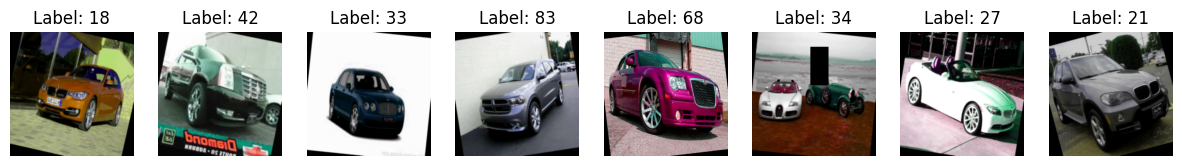

In [15]:
visualize_samples(dataset=train_dataset)

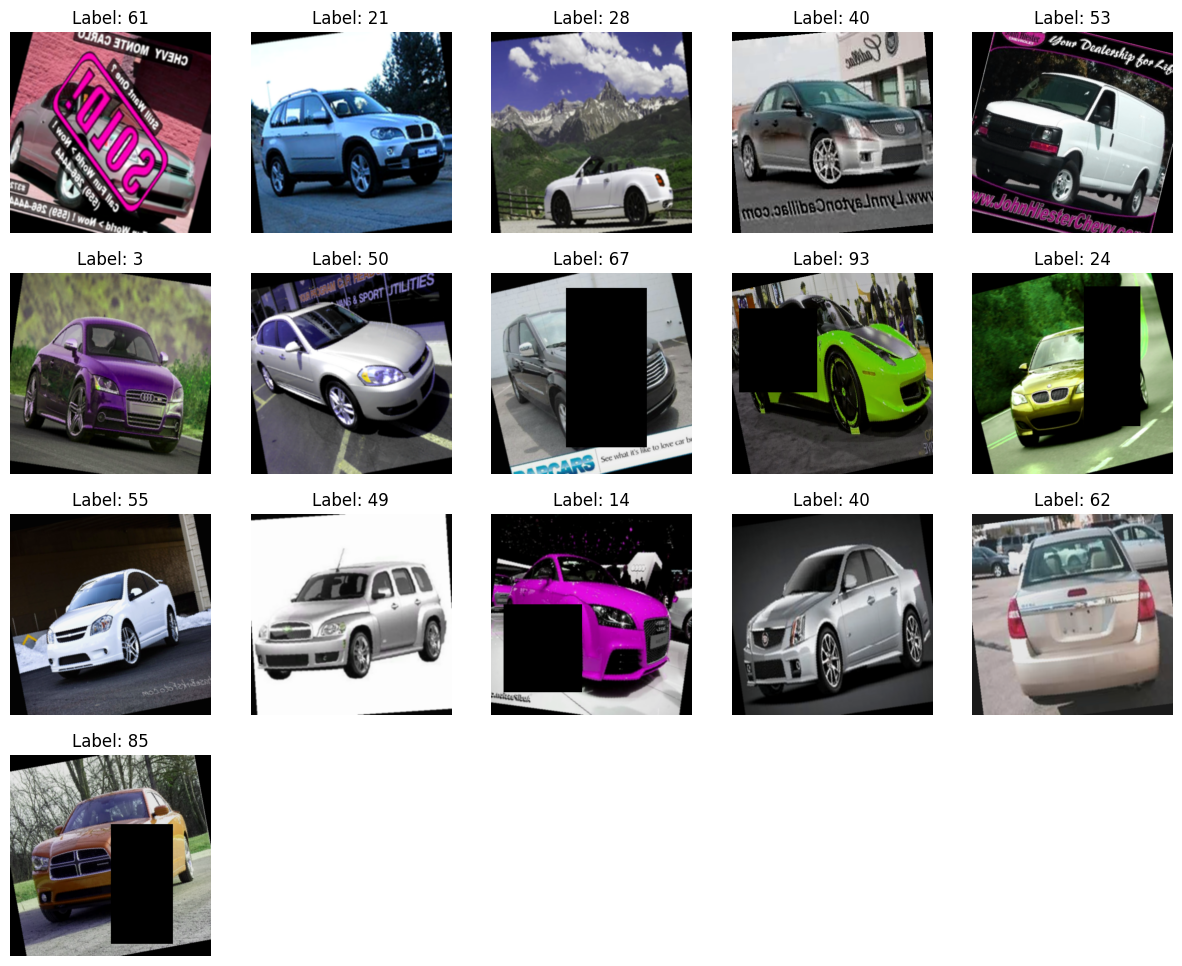

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 16, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle = True)

visualize_batch(train_dataloader)

# Model Architecture

In [26]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.model = nn.Sequential (
            # 3*512*512
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), 
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.ReLU(),
            # 32*256*256
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU(),
            # 64*128*128
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.ReLU(),
            # 128*64*64
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU(),
            # 64 * 32*32
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.ReLU(),
            # 32*16*16
            nn.Flatten(),
            nn.Linear(in_features=32*16*16, out_features=num_classes)
        )

    def forward(self, x):
        return self.model(x)




In [27]:
model = CNN(100)

# Training loop

In [28]:
batch_size = 16
device = torch.device("mps" )
model = model.to(device)
print(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

mps


In [29]:
def evaluation(model, loader, criterion, device, phase='Valid'):
  model.eval()
  predictions = []
  ground_truth = []
  with torch.no_grad():
    total_loss = 0
    total  = 0
    correct = 0
    for batch_index, (images, labels) in enumerate(loader):
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * images.size(0)
      total += images.size(0)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds.cpu().numpy())
      ground_truth.extend(labels.cpu().numpy())
      correct += (preds == labels).sum().item()
    accuracy = correct / total
    loss = total_loss / total
    print(f'     {phase} Accuracy={accuracy:<10.4f}  Loss= {loss:<10.4f}')
    return {'loss': loss,
            'accuracy': accuracy,
            'ground_truth': ground_truth,
            'predictions': predictions}

In [31]:
def training(model, train_loader, valid_loader, criterion, optimizer, device,
             epochs, best_model_path):
  model.train()
  best_loss = torch.inf
  best_restults = None
  for epoch in range(epochs):
    total_loss = 0
    total  = 0
    correct = 0
    for batch_index, (images, labels) in enumerate(train_loader):
      optimizer.zero_grad()
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * images.size(0)
      total += images.size(0)
      _, preds = torch.max(outputs, 1)
      correct += (preds == labels).sum().item()
    accuracy = correct / total
    loss = total_loss / total
    print(f'{epoch:<4} Train Accuracy={accuracy:<10.4f}  Loss= {loss:<10.4f}')
    results = evaluation(model, valid_loader, criterion, device)
    if results['loss'] < best_loss:
      torch.save(model, best_model_path)
      best_loss = results['loss']
      best_restults = results
    print()
  return best_restults

In [32]:
epochs = 10
best_model_path = '/Users/alijohnnaqvi/Desktop/ best_model.pt'
best_restults = training(model, train_dataloader, valid_dataloader, criterion,
                         optimizer, device, epochs, best_model_path)

0    Train Accuracy=0.0121      Loss= 4.7975    
     Valid Accuracy=0.0133      Loss= 4.5735    

1    Train Accuracy=0.0245      Loss= 4.5495    
     Valid Accuracy=0.0181      Loss= 4.5466    

2    Train Accuracy=0.0225      Loss= 4.5315    
     Valid Accuracy=0.0218      Loss= 4.5488    

3    Train Accuracy=0.0259      Loss= 4.4961    
     Valid Accuracy=0.0230      Loss= 4.5729    

4    Train Accuracy=0.0363      Loss= 4.4578    
     Valid Accuracy=0.0266      Loss= 4.5366    

5    Train Accuracy=0.0352      Loss= 4.4260    
     Valid Accuracy=0.0266      Loss= 4.5459    

6    Train Accuracy=0.0356      Loss= 4.3969    
     Valid Accuracy=0.0278      Loss= 4.6638    

7    Train Accuracy=0.0418      Loss= 4.3629    
     Valid Accuracy=0.0266      Loss= 4.5378    

8    Train Accuracy=0.0525      Loss= 4.3324    
     Valid Accuracy=0.0254      Loss= 4.6015    

9    Train Accuracy=0.0570      Loss= 4.3118    
     Valid Accuracy=0.0218      Loss= 4.6039    

